# DRC Roads Temporal Analysis



Keywords: temporal analysis, forest monitoring, classification

In [1]:
import datetime
import json
import os

import numpy as np
import pandas as pd
from planet import api

In [2]:
# Import functionality from local notebooks
from ipynb.fs.defs.drc_roads_download import get_overlapping_scenes, StripDownloader, StripSearcher
from ipynb.fs.defs.drc_roads_classification \
    import Timer, load_training_data, classify_forest, classified_band_to_rgb

## Download Scenes

In this section, we use the ipynb module to import `StripDownloader` from the [drc_roads_download](drc_roads_download.ipynb) notebook. We then use `StripDownloader` to download the portion of OrthoTile strips that overlap the AOI.

### Load data from drc_roads_download notebook

In [3]:
# load aoi. Saved in drc_roads_download notebook
aoi_geojson_filename = os.path.join('pre-data', 'aoi.geojson')

### Download portions of OrthoTile strips that overlap AOI

In [4]:
# create planet api client
planet_api_key = os.environ['PL_API_KEY']

# quick check that key is defined
assert planet_api_key, "PL_API_KEY not defined."

client = api.ClientV1(api_key=planet_api_key)

In [5]:
# load aoi json
with open(aoi_geojson_filename) as json_data:
    aoi = json.load(json_data)

In [6]:
# get good overlapping scenes from to July 2017 to February 2018
begin=datetime.datetime(year=2017,month=7,day=1)
end=datetime.datetime(year=2018,month=3,day=1)
strip_searcher = StripSearcher(aoi, begin, end, client)
good_scenes = strip_searcher.search(aoi_geojson_filename)

500 OrthoTiles were returned from the api search.
There are 494 OrthoTiles that overlap aoi.
There are 144 OrthoTiles in 36 strips that significantly overlap the aoi.
36 strips
found data/943459_udm_mosaic.tif
found data/904538_udm_mosaic.tif
found data/915538_udm_mosaic.tif
found data/883193_udm_mosaic.tif
found data/879726_udm_mosaic.tif
found data/863467_udm_mosaic.tif
found data/758681_udm_mosaic.tif
found data/741529_udm_mosaic.tif
found data/739199_udm_mosaic.tif
1091588_3539508_2018-01-20_1001
1043874_3539508_2018-01-06_0c24
1043874_3539607_2018-01-06_0c24
1043874_3539608_2018-01-06_0c24
1043874_3539507_2018-01-06_0c24
downloading ['1043874_3539507_2018-01-06_0c24', '1043874_3539608_2018-01-06_0c24', '1043874_3539607_2018-01-06_0c24', '1043874_3539508_2018-01-06_0c24'] as data/1043874_udm_mosaic.tif
1114901_3539607_2018-01-27_0f28
1114901_3539608_2018-01-27_0f28
1114901_3539508_2018-01-27_0f28
1114901_3539507_2018-01-27_0f28
downloading ['1114901_3539507_2018-01-27_0f28', '11149

636659_3539607_2017-07-21_1024
636659_3539507_2017-07-21_1024
636659_3539608_2017-07-21_1024
636659_3539508_2017-07-21_1024
downloading ['636659_3539508_2017-07-21_1024', '636659_3539608_2017-07-21_1024', '636659_3539507_2017-07-21_1024', '636659_3539607_2017-07-21_1024'] as data/636659_udm_mosaic.tif
666617_3539507_2017-08-04_1007
666617_3539508_2017-08-04_1007
666617_3539607_2017-08-04_1007
666617_3539608_2017-08-04_1007
downloading ['666617_3539608_2017-08-04_1007', '666617_3539607_2017-08-04_1007', '666617_3539508_2017-08-04_1007', '666617_3539507_2017-08-04_1007'] as data/666617_udm_mosaic.tif
651530_3539607_2017-07-28_0f17
651530_3539507_2017-07-28_0f17
651530_3539608_2017-07-28_0f17
651530_3539508_2017-07-28_0f17
downloading ['651530_3539508_2017-07-28_0f17', '651530_3539608_2017-07-28_0f17', '651530_3539507_2017-07-28_0f17', '651530_3539607_2017-07-28_0f17'] as data/651530_udm_mosaic.tif
699281_3539607_2017-08-20_0e1f
699281_3539608_2017-08-20_0e1f
699281_3539507_2017-08-20_0e1

In [7]:
asset_type = 'analytic'
strip_downloader = StripDownloader(good_scenes, aoi_geojson_filename, client)
strip_downloader.run(asset_type, overwrite=False, verbose=True)

21 strips
found data/1176905_analytic_mosaic.tif
found data/1153620_analytic_mosaic.tif
found data/1130991_analytic_mosaic.tif
found data/1127986_analytic_mosaic.tif
found data/1124454_analytic_mosaic.tif
found data/1121892_analytic_mosaic.tif
found data/1114901_analytic_mosaic.tif
found data/1091588_analytic_mosaic.tif
found data/1085449_analytic_mosaic.tif
found data/1081381_analytic_mosaic.tif
found data/1047845_analytic_mosaic.tif
found data/1043827_analytic_mosaic.tif
found data/1037433_analytic_mosaic.tif
found data/943459_analytic_mosaic.tif
found data/758681_analytic_mosaic.tif
found data/741529_analytic_mosaic.tif
found data/739199_analytic_mosaic.tif
found data/699281_analytic_mosaic.tif
found data/651530_analytic_mosaic.tif
found data/666617_analytic_mosaic.tif
found data/636659_analytic_mosaic.tif
Nothing to download


### Get mosaic image names

In [8]:
# sort strip ids as integers. Strip id order is the same as strip temporal order
strip_ids = [int(s) for s in good_scenes.strip_id.unique().tolist()]
strip_ids.sort()
strip_ids = [str(s) for s in strip_ids]

In [9]:
strip_mosaics = [strip_downloader.get_filename(i, asset_type) for i in strip_ids]

In [10]:
strip_mosaics

['data/636659_analytic_mosaic.tif',
 'data/651530_analytic_mosaic.tif',
 'data/666617_analytic_mosaic.tif',
 'data/699281_analytic_mosaic.tif',
 'data/739199_analytic_mosaic.tif',
 'data/741529_analytic_mosaic.tif',
 'data/758681_analytic_mosaic.tif',
 'data/943459_analytic_mosaic.tif',
 'data/1037433_analytic_mosaic.tif',
 'data/1043827_analytic_mosaic.tif',
 'data/1047845_analytic_mosaic.tif',
 'data/1081381_analytic_mosaic.tif',
 'data/1085449_analytic_mosaic.tif',
 'data/1091588_analytic_mosaic.tif',
 'data/1114901_analytic_mosaic.tif',
 'data/1121892_analytic_mosaic.tif',
 'data/1124454_analytic_mosaic.tif',
 'data/1127986_analytic_mosaic.tif',
 'data/1130991_analytic_mosaic.tif',
 'data/1153620_analytic_mosaic.tif',
 'data/1176905_analytic_mosaic.tif']

## Classify Scenes

In this section, we use the ipynb module to import classification functionality from the [drc_roads_classification](drc_roads_classification.ipynb) notebook.

In [11]:
X_training, y_training = load_training_data()

In [12]:
with Timer():
    classified_bands = [classify_forest(img, X_training, y_training)
                        for img in strip_mosaics]

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
7 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
7 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
8 seconds
0 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


7 seconds
0 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


6 seconds
0 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


6 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
6 seconds
0 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


7 seconds
0 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


8 seconds
0 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


7 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
8 seconds
0 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


7 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
7 seconds
0 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


7 seconds
0 seconds

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



7 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
8 seconds
0 seconds

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



7 seconds
0 seconds

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



7 seconds
0 seconds

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



9 seconds
0 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


8 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
8 seconds
390 seconds


In [14]:
# We only have two values, 0 and 1. Convert to uint8 for memory. 
classified_bands = [band.astype(np.uint8) for band in classified_bands]

In [22]:
# b_classified_bands = [(b==0).astype(np.bool) for b in classified_bands]
# np.savez('data/classified_bands.npz', *b_classified_bands)

### Visualize Classified Scenes

In [15]:
import visual

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


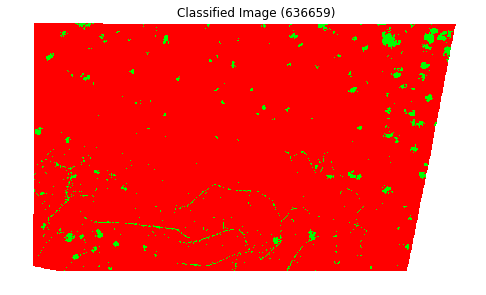

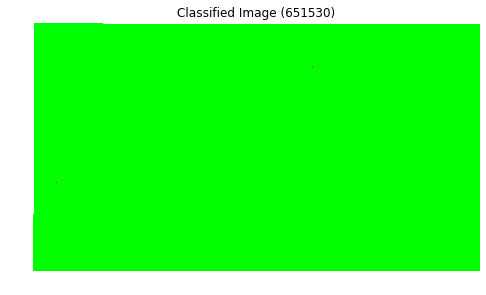

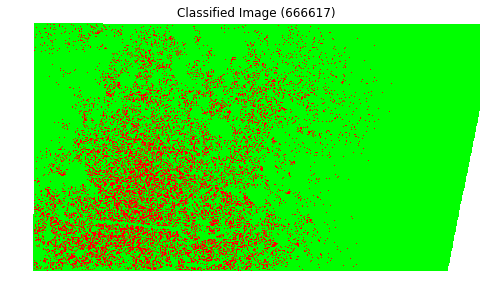

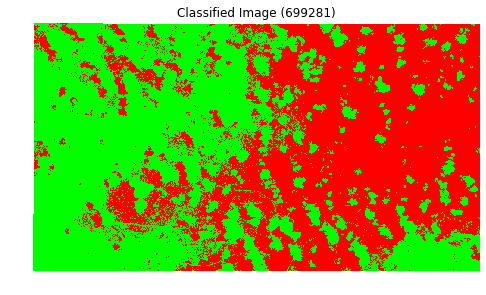

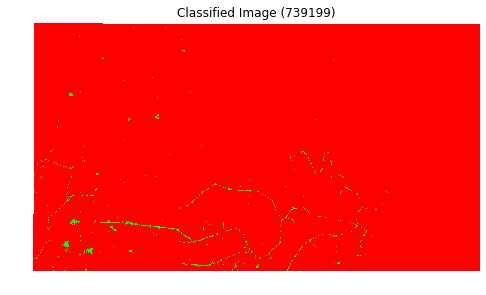

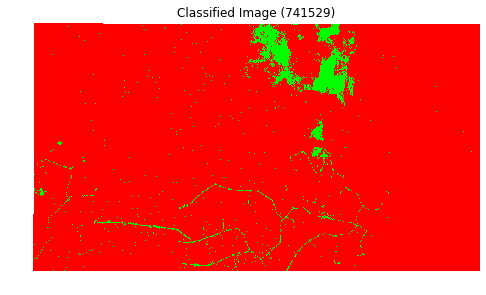

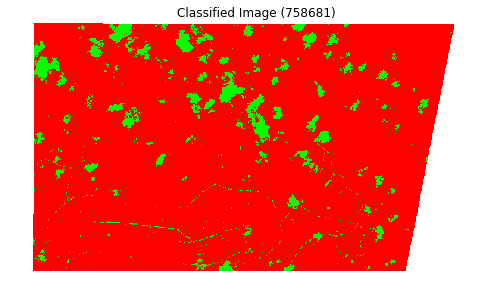

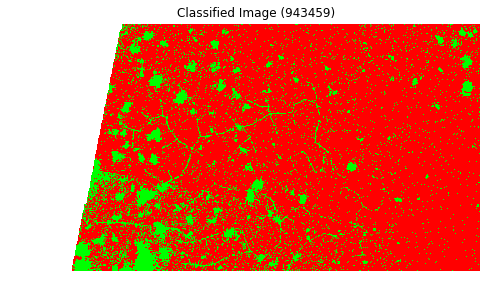

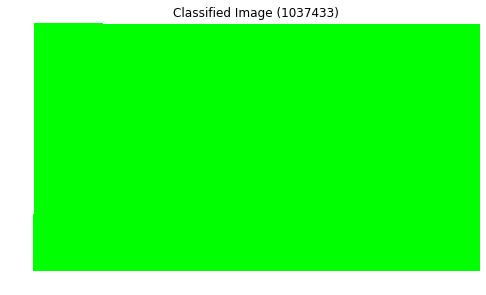

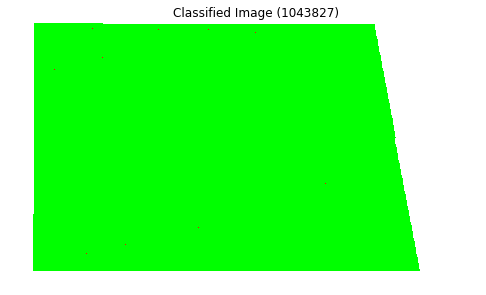

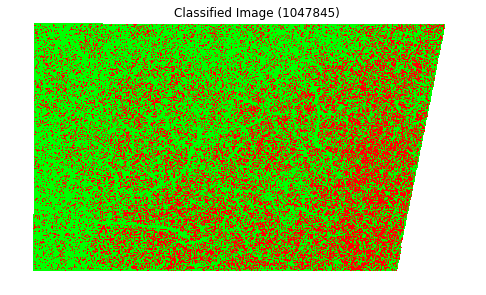

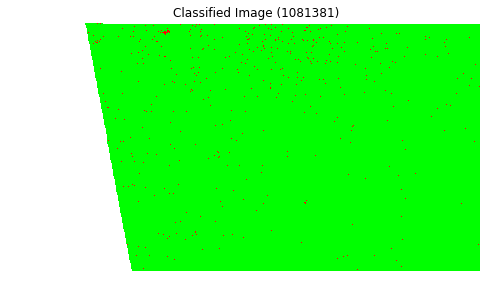

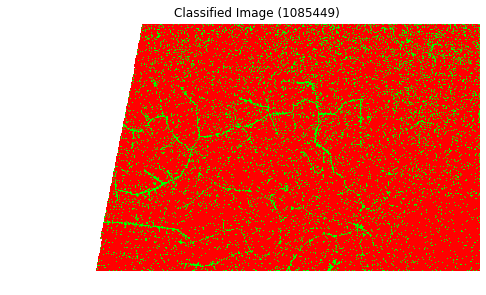

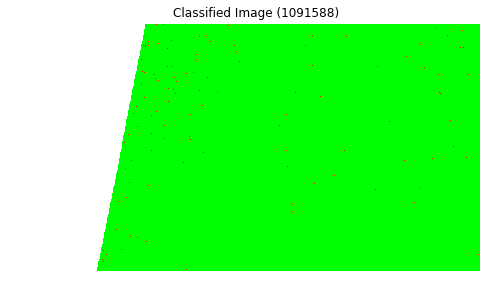

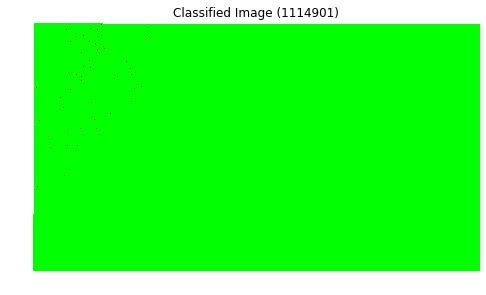

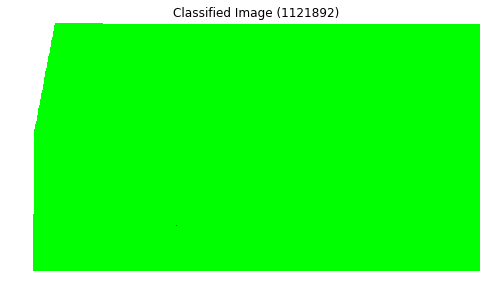

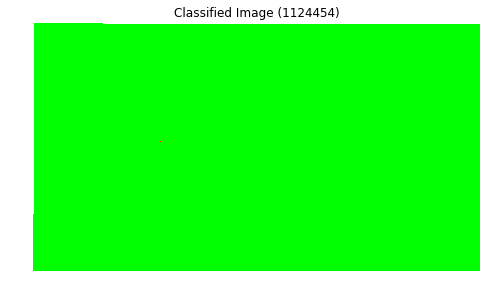

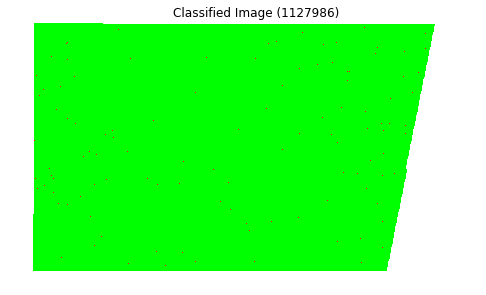

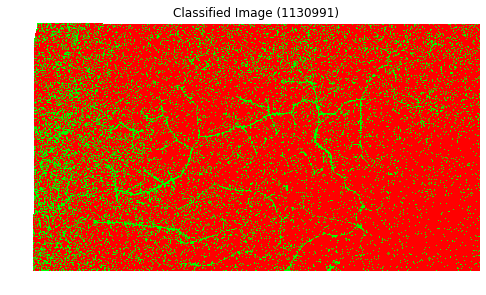

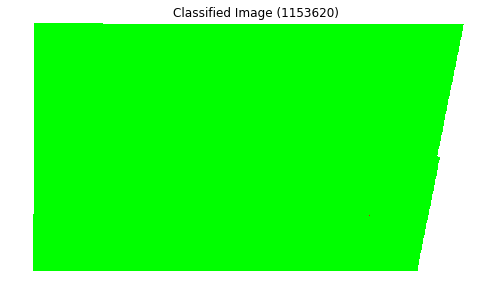

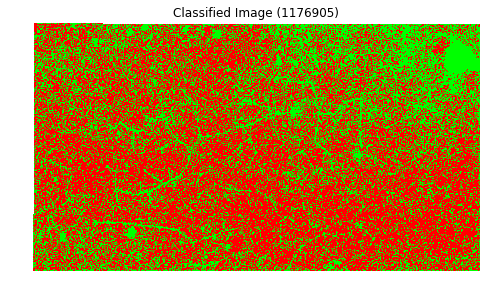

In [30]:
# Decimate classified arrays for memory conservation
def decimate(arry, num=8):
    return arry[::num, ::num].copy()

for classified_band, strip_id in zip(classified_bands, strip_ids):
    visual.plot_image(classified_band_to_rgb(decimate(classified_band)),
                      title='Classified Image ({})'.format(strip_id),
                      figsize=(8, 8))

The results of classification in these images is mixed. There are a few images where the UDM fails to identify clouds (e.g. 1114901) and few images where the results actually look pretty good but classification missfires and classifies everything as non-forest (e.g. 1091588). There may be uniform in the imagery that makes it brighter than usual, which causes the classifier to fail. Ultimately, visual inspection finds that about 8 of the 21 classified images looks informative.

## Temporal Classification

Lets look at the time series information for each pixel and see if we can identify true change

In [ ]:
def get_strip_date(strip_id):
    strip_scenes = overlapping_scenes[overlapping_scenes.strip_id == strip_id]
    strip_dates = set([a.date() for a in strip_scenes.acquired.tolist()])
    assert len(strip_dates) == 1
    return strip_dates.pop()

test_strip_id = '943459'
get_strip_date(test_strip_id)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# get time series for each unmasked pixel
pixel_timeseries = np.ma.compress_cols(np.ma.dstack(classified_bands).transpose(2, 0, 1).reshape(9, -1)).transpose(1,0)
pixel_timeseries.shape

In [ ]:
def make_sample(pixels, count):
    pixel_sample = pixels.copy()
    np.random.shuffle(pixel_sample) # only shuffles along the first axis
    pixel_sample = pixel_sample[:count, :]
    return pixel_sample

make_sample(pixel_timeseries, 6).shape

In [ ]:
def make_same_size_samples(list_of_pixel_sets):
    sample_len = min([p.shape[0] for p in list_of_pixel_sets])

    def sample_pixels(pixels):
        if pixels.shape[0] > sample_len:
            pixel_sample = make_sample(pixels, sample_len)
        else:
            pixel_sample = pixels
        return pixel_sample
    
    return [sample_pixels(p)
            for p in list_of_pixel_sets]

forest_pixels = pixel_timeseries[pixel_timeseries[:,0] == 0]
non_forest_pixels = pixel_timeseries[pixel_timeseries[:,0] == 1]
forest_pixels_sample, non_forest_pixels_sample = make_same_size_samples([forest_pixels, non_forest_pixels])
print(forest_pixels_sample.shape)
print(non_forest_pixels_sample.shape)

In [ ]:
forest_plot_sample = make_sample(forest_pixels_sample, 6)
non_forest_plot_sample = make_sample(non_forest_pixels_sample, 6)

In [ ]:
plt.figure()
for i, pixel in enumerate(forest_plot_sample):
    plt.plot(np.array(range(len(pixel))), pixel, 'o--', label=i)
# plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.figure()
for i, pixel in enumerate(non_forest_plot_sample):
    plt.plot(np.array(range(len(pixel))), pixel, 'o--', label=i)
# plt.legend(loc='upper left')
plt.show()